In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
from wandb_utils import *
from data import *
from compcor.corpus_metrics import chi_square_distance, zipf_distance

synthetic_datasets = {d.name: JSONLDataset(d.path) for d in SYNTHETIC_DATASETS}
train_dataset = JSONLDataset(DATASET_TRAIN.path)[:12800]

all_datasets = {"train": train_dataset}
all_datasets.update(synthetic_datasets)

In [26]:
import re


for name, dataset in all_datasets.items():
    print(name)
    example = dataset[8]
    code = example.get("function", example.get("code"))
    print(re.sub(r'"""[\s\S]*?"""', '"""' + example.get("docstring") + '"""', code, count=1))
    print()

train
def rev_c(read):
    """return reverse completment of read"""
    rc = []
    rc_nucs = {'A':'T', 'T':'A', 'G':'C', 'C':'G', 'N':'N'}
    for base in read:
        rc.extend(rc_nucs[base.upper()])
    return rc[::-1]

c2d_semisynthetic
def rev_c(read):
    """This function takes a DNA sequence string as input and returns the reverse complement of the sequence. The reverse complement is obtained by replacing each nucleotide with its complement (A with T, T with A, G with C, C with G) and reversing the resulting sequence. The function uses a dictionary to map each nucleotide to its complement."""
    rc = []
    rc_nucs = {'A':'T', 'T':'A', 'G':'C', 'C':'G', 'N':'N'}
    for base in read:
        rc.extend(rc_nucs[base.upper()])
    return rc[::-1]

d2c_semisynthetic
def reverse_complement(read):
    """Returns the reverse complement of a given DNA sequence.

    Parameters:
    read (str): The DNA sequence to be reverse complemented.

    Returns:
    str: The reverse complement o

In [3]:
from token import EXACT_TOKEN_TYPES
python_keywords = [
    "False",
    "None",
    "True",
    "and",
    "as",
    "assert",
    "async",
    "await",
    "break",
    "class",
    "continue",
    "def",
    "del",
    "elif",
    "else",
    "except",
    "finally",
    "for",
    "from",
    "global",
    "if",
    "import",
    "in",
    "is",
    "lambda",
    "nonlocal",
    "not",
    "or",
    "pass",
    "raise",
    "return",
    "try",
    "while",
    "with",
    "yield",
] + list(EXACT_TOKEN_TYPES.keys())

In [4]:
all_datasets["train"][0].keys()

dict_keys(['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'idx'])

In [5]:

# def count_tokens(dataset):
#     code_counter = Counter()
#     nl_counter = Counter()
#     for example in dataset:
#         if "code_tokens" not in example and "function_tokens" not in example:
#             raise ValueError(example)
#         code_counter.update(example.get("code_tokens", example.get("function_tokens")))
#         nl_counter.update(example["docstring_tokens"])
#     return code_counter, nl_counter

# dataset_counters = {name: count_tokens(dataset) for name, dataset in all_datasets.items()}

In [4]:
from collections import Counter

def calc_dataset_stats_df(dataset):
    code_counters = []
    nl_counters = []
    for example in dataset:
        if "code_tokens" not in example and "function_tokens" not in example:
            raise ValueError(example)
        code_tokens = example.get("function_tokens", example.get("code_tokens"))
        code_counters.append(Counter(code_tokens))
        nl_counters.append(Counter(example["docstring_tokens"]))
    df = pd.DataFrame({"code_counter": code_counters, "nl_counter": nl_counters})
    df["n_code"] = df.code_counter.apply(lambda c: sum(c.values()))
    df["n_nl"] = df.nl_counter.apply(lambda c: sum(c.values()))
    df["n_code_unique"] = df.code_counter.apply(len)
    df["n_nl_unique"] = df.nl_counter.apply(len)

    return df

dataset_stats_dfs = {name: calc_dataset_stats_df(dataset) for name, dataset in all_datasets.items()}
for name, df in dataset_stats_dfs.items():
    df["dataset"] = name

In [66]:
sns.color_palette("pastel")

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [5]:
label_palette = {
    "Baseline - code": "tab:blue",
    "Baseline - docstring": "tab:cyan",
    "C2D - docstring": "tab:orange",
    "C2D - code": "tab:blue",    
    "D2C - code": "tab:red",
    "D2C - docstring": "tab:cyan",
    "H+ - docstring": "tab:brown",
    "H+ - code": "tab:gray",
    "H- - docstring": "tab:purple",
    "H- - code": "tab:pink",
    "Taxonomical - docstring": "tab:green",
    "Taxonomical - code": "tab:olive",
}

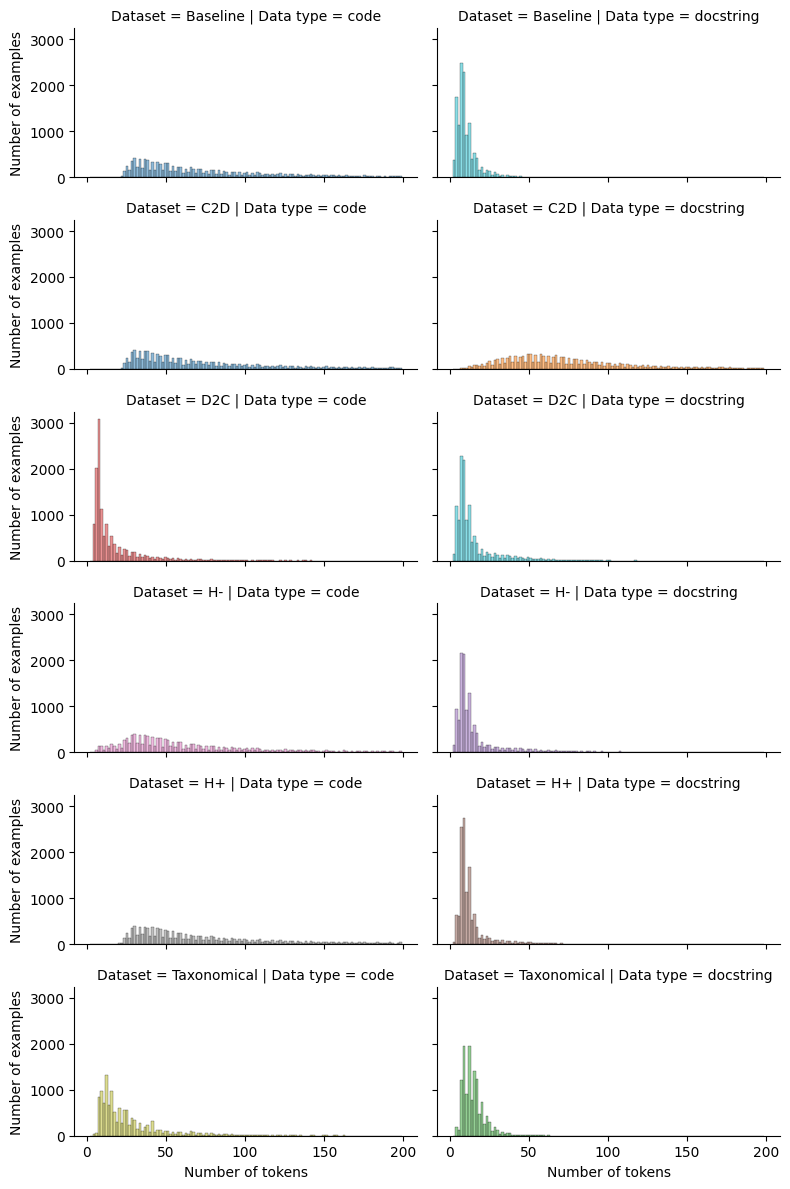

In [6]:
df = pd.concat([df for df in dataset_stats_dfs.values()], axis=0)
# df = dataset_stats_dfs["train"]
# df = df[(df["n_code"] < 200) & (df["n_nl"] < 200)]

# melt to combine n_code and n_nl
code_var, nl_var = "n_code", "n_nl"
# code_var, nl_var = "n_code_unique", "n_nl_unique"

df = df.melt(id_vars=["dataset"], value_vars=[code_var, nl_var], value_name="n", var_name="Data type")
df = df[df["n"] < (100 if code_var.endswith("unique") else 200)]

df = df.replace(
    {
        "dataset": {
            "c2d_semisynthetic": "C2D",
            "d2c_semisynthetic": "D2C",
            "subconcepts_8_synthetic": "Taxonomical",
            "hardpositive_semisynthetic": "H+",
            "hardnegative_semisynthetic": "H-",
            "train": "Baseline",
        },
        "Data type" : {code_var: "code", nl_var: "docstring"},
    }
)
df["hue"] = df["dataset"] + " - " + df["Data type"]

df = df.rename(columns={"dataset": "Dataset"})

g = sns.displot(
    df,
    x="n",
    col="Data type",
    row="Dataset",
    hue="hue",
    palette=label_palette,
    kind="hist",
    fill=True,
    aspect=2,
    height=2,
    legend=False,
)
g.set(xlabel="Number of tokens", ylabel="Number of examples")
# g.set(yscale="log")

In [91]:
from collections import defaultdict

rows = defaultdict(list)
for name, stats_df in dataset_stats_dfs.items():
    rows["dataset"].append(name)
    code_c = Counter()
    nl_c = Counter()
    for c in stats_df["code_counter"]:
        code_c.update(c)
    for c in stats_df["nl_counter"]:
        nl_c.update(c)
    # print(stats_df["code_counter"].sum())
    

    rows["code_counter"].append(code_c)
    rows["nl_counter"].append(nl_c)

counter_df = pd.DataFrame(rows)
counter_df.set_index("dataset", inplace=True)
counter_df

,code_counter,nl_counter
dataset,,
train,"{'def': 13527, 'split_phylogeny': 1, '(': 1024...","{'Return': 686, 'either': 59, 'the': 9346, 'fu..."
c2d_semisynthetic,"{'def': 13527, 'split_phylogeny': 1, '(': 1024...","{'This': 11798, 'function': 23158, 'splits': 2..."
d2c_semisynthetic,"{'def': 12987, 'truncate_taxonomy': 1, '(': 21...","{'Return': 712, 'either': 60, 'the': 13428, 'f..."
hardnegative_semisynthetic,"{'def': 13414, 'split_phylogeny': 1, '(': 8432...","{'Return': 562, 'a': 9628, 'truncated': 2, 've..."
hardpositive_semisynthetic,"{'def': 13628, 'truncate_taxonomy_string': 1, ...","{'Truncate': 2, 'a': 8793, 'taxonomy': 1, 'str..."
subconcepts_8_synthetic,"{'def': 13195, 'add_numbers': 76, '(': 32371, ...","{'This': 7101, 'function': 7566, 'takes': 3060..."


In [95]:
# Assemble most common tokens into a table
code_cols = {}
nl_cols = {}

dataset_names = {
    "c2d_semisynthetic": "C2D",
    "d2c_semisynthetic": "D2C",
    "subconcepts_8_synthetic": "Taxonomical",
    "hardpositive_semisynthetic": "H+",
    "hardnegative_semisynthetic": "H-",
    "train": "Baseline",
}

for name, row in counter_df.iterrows():
    code_cols[dataset_names[name]] = row["code_counter"].most_common(10)
    nl_cols[dataset_names[name]] = row["nl_counter"].most_common(10)

top_code_df = pd.DataFrame(code_cols)
top_nl_df = pd.DataFrame(nl_cols)

In [96]:
top_code_df

,Baseline,C2D,D2C,H-,H+,Taxonomical
0,"((, 102487)","((, 102487)","((, 21245)","(), 84324)","(), 98464)","((, 32371)"
1,"(), 102487)","(), 102487)","(), 21245)","((, 84320)","((, 98463)","(), 32369)"
2,"(., 94435)","(., 94435)","(:, 19504)","(., 74135)","(., 91593)","(:, 26879)"
3,"(,, 74499)","(,, 74499)","(def, 12987)","(,, 61241)","(,, 72564)","(,, 14814)"
4,"(=, 65095)","(=, 65095)","(,, 12124)","(=, 53001)","(=, 66590)","(def, 13195)"
5,"(:, 57264)","(:, 57264)","(=, 7766)","(:, 50140)","(:, 56901)","(=, 12579)"
6,"(self, 35139)","(self, 35139)","(pass, 5763)","(self, 29969)","(self, 33908)","(return, 11789)"
7,"([, 27542)","([, 27542)","(., 5591)","([, 22293)","([, 26381)","([, 9798)"
8,"(], 27542)","(], 27542)","(return, 4223)","(], 22293)","(], 26381)","(], 9798)"
9,"(if, 19209)","(if, 19209)","(], 2831)","(if, 15789)","(if, 18796)","(., 8654)"


In [97]:
top_nl_df

,Baseline,C2D,D2C,H-,H+,Taxonomical
0,"(., 10318)","(the, 97969)","(., 15012)","(the, 19255)","(., 15828)","(the, 14913)"
1,"(the, 9346)","(., 64180)","(the, 13428)","(., 18042)","(the, 14325)","(., 13693)"
2,"(a, 5801)","(a, 34954)","(a, 7424)","(a, 9628)","(a, 8793)","(a, 12200)"
3,"(to, 3648)","(and, 28014)","(:, 6235)","(:, 7083)","(of, 4537)","(function, 7566)"
4,"(of, 3104)","(is, 24517)","(to, 5178)","(of, 6465)","(:, 4262)","(This, 7101)"
5,"(and, 2169)","(function, 23158)","(of, 4635)","(to, 5593)","(to, 4002)","(and, 6552)"
6,"(for, 2152)","(to, 22850)","(and, 2796)","(and, 4193)","(and, 3123)","(of, 6226)"
7,"(in, 1595)","(of, 21821)","(for, 2589)","(function, 3885)","(for, 2267)","(returns, 3575)"
8,"(from, 1576)","(it, 16162)","(Returns, 2278)","(The, 3031)","(in, 1857)","(list, 3243)"
9,"(is, 1159)","(The, 14427)","(-, 2249)","(This, 3003)","(given, 1836)","(takes, 3060)"


KeyboardInterrupt: 

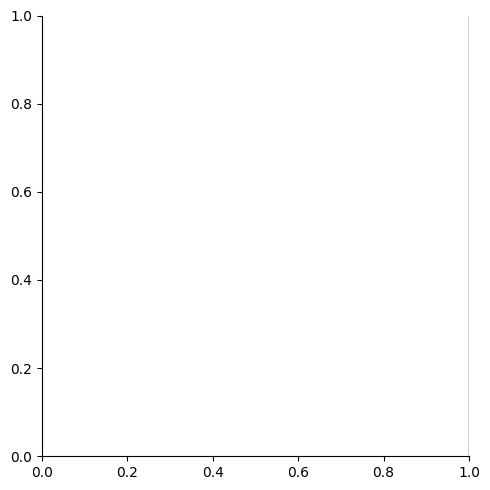

In [18]:
def plot_token_counts(code_counter, nl_counter, title=None, ax=None):
    df = pd.DataFrame({
        "type": "code",
        "token": list(code_counter.keys()),
        "count": list(code_counter.values()),
    })
    df = pd.concat((df, pd.DataFrame({
        "type": "docstring",
        "token": list(nl_counter.keys()),
        "count": list(nl_counter.values()),
    })), axis=0)

    # df = df[(df["count"] > 200) & (df["type"] == "code")]
    df = df[df["type"] == "code"]
    df = df.sort_values("count", ascending=False)
    return sns.displot(df["count"])
    

plot_token_counts(*dataset_counters["c2d_semisynthetic"])

In [7]:


distance = chi_square_distance(corpus1=tokensA, corpus2=tokensB)
print("chi_square_distance={}".format(distance))

distance = zipf_distance(corpus1=tokensA, corpus2=tokensB)
print("zipf_distance={}".format(distance))


NameError: name 'tokensA' is not defined